<a href="https://colab.research.google.com/github/soumya-r13/secure-encryption-with-adversarial-neural-cryptography/blob/main/different_block_sizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Block Size 16, Epoch 1/250, Train Loss_AB: 2.041630506515503, Train Loss_E: 15.95317554473877, Test Loss_AB: 2.126296043395996, Test Loss_E: 16.234355926513672
Block Size 16, Epoch 2/250, Train Loss_AB: 2.0419623851776123, Train Loss_E: 15.951777458190918, Test Loss_AB: 2.1272881031036377, Test Loss_E: 16.235071182250977
Block Size 16, Epoch 3/250, Train Loss_AB: 2.042339324951172, Train Loss_E: 15.950577735900879, Test Loss_AB: 2.128305435180664, Test Loss_E: 16.235876083374023
Block Size 16, Epoch 4/250, Train Loss_AB: 2.042731523513794, Train Loss_E: 15.949509620666504, Test Loss_AB: 2.129326581954956, Test Loss_E: 16.236713409423828
Block Size 16, Epoch 5/250, Train Loss_AB: 2.0431153774261475, Train Loss_E: 15.948522567749023, Test Loss_AB: 2.1303348541259766, Test Loss_E: 16.237548828125
Block Size 16, Epoch 6/250, Train Loss_AB: 2.043485164642334, Train Loss_E: 15.947614669799805, Test Loss_AB: 2.1313068866729736, Test Loss_E: 16.23833465576172
Block Size 16, Epoch 7/250, Train 

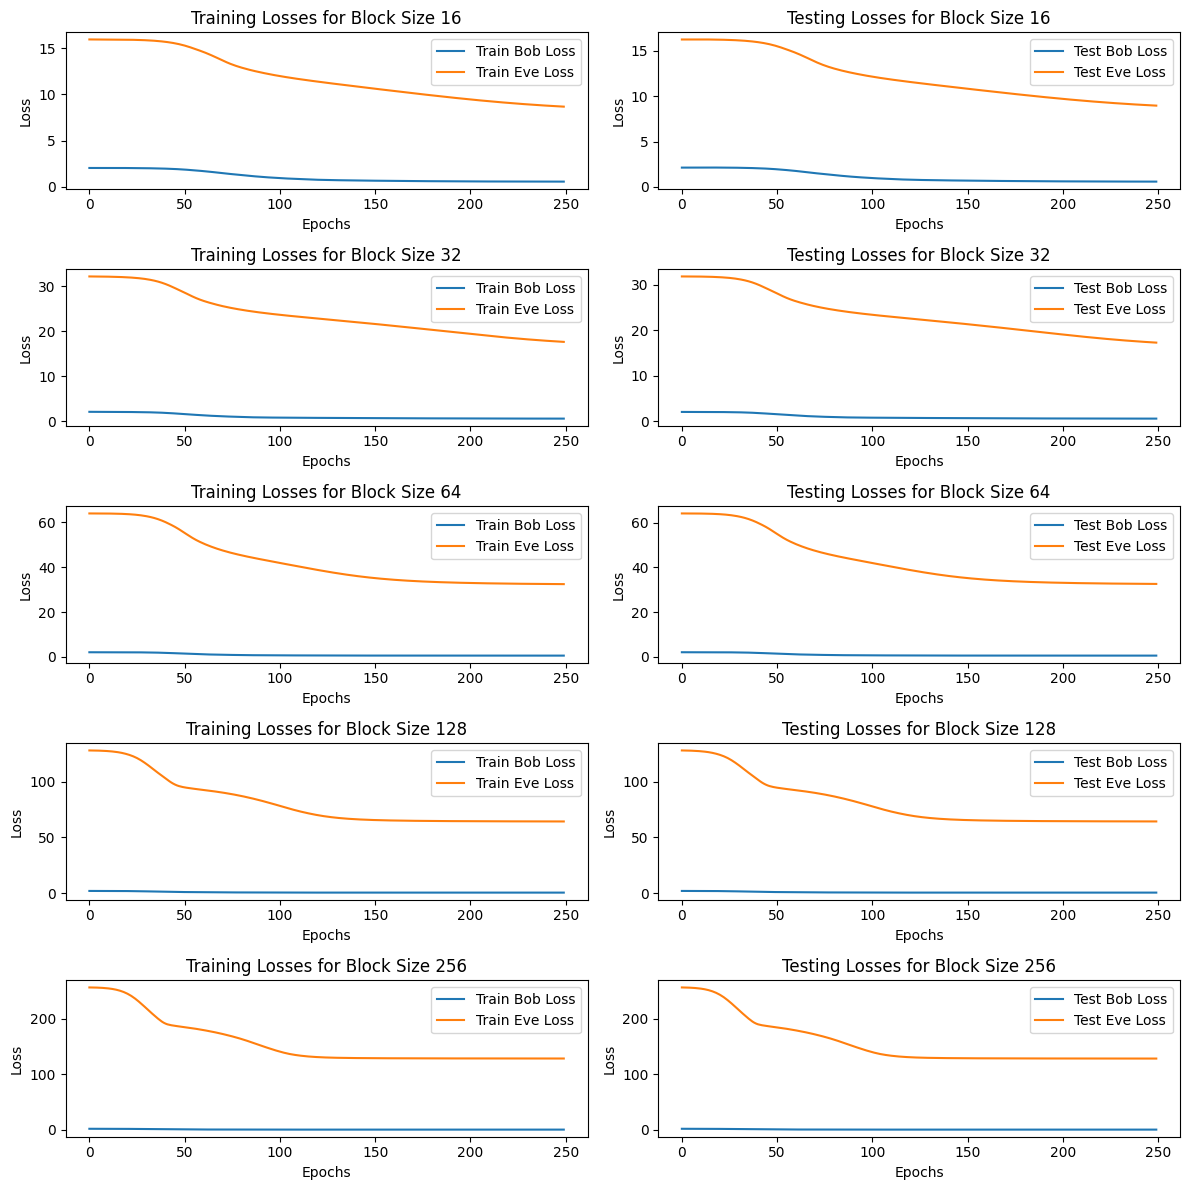

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
import numpy as np
import matplotlib.pyplot as plt

def generate_data(batch_size, seq_length):
    messages = np.random.choice([-1, 1], size=(batch_size, seq_length, 1)).astype(np.float32)
    keys = np.random.choice([-1, 1], size=(batch_size, seq_length, 1)).astype(np.float32)
    return messages, keys

def model_alice(seq_length):
    model = models.Sequential()
    model.add(layers.Conv1D(seq_length, 3, padding='same', input_shape=(None, 2)))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))
    return model

def model_bob(seq_length):
    model = models.Sequential()
    model.add(layers.Conv1D(seq_length, 3, padding='same', input_shape=(None, 2)))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))
    return model

def model_eve(seq_length):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(seq_length, 1)))
    model.add(layers.Dense(seq_length, activation='relu'))
    model.add(layers.Dense(seq_length*2, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def separation(alice_input, bob_output):
    separation_value = tf.reduce_sum(tf.abs(tf.subtract(alice_input, bob_output)), axis=1)
    return separation_value

def eve_vs_random_guess(alice_input, eve_output, seq_length):
    loss = tf.square(seq_length/2 - separation(alice_input, eve_output)) / (seq_length/2) ** 2
    return tf.reduce_mean(loss)

def combined_loss_function(alice_input, decipher_bob, eve_output, seq_length):
    loss = separation(alice_input, decipher_bob)/seq_length + eve_vs_random_guess(alice_input, eve_output, seq_length)
    return tf.reduce_mean(loss)

def attacker_loss(alice_input, eve_output):
    loss = separation(alice_input, eve_output)
    return tf.reduce_mean(loss)

block_sizes = [16, 32, 64, 128, 256]
num_epochs = 250
batch_size = 64
train_size = 1000
test_size = 200

results = []

for seq_length in block_sizes:
    train_messages, train_keys = generate_data(train_size, seq_length)
    test_messages, test_keys = generate_data(test_size, seq_length)

    alice = model_alice(seq_length)
    bob = model_bob(seq_length)
    eve = model_eve(seq_length)

    optimizer_ab = optimizers.Adam(learning_rate=0.0008)
    optimizer_e = optimizers.Adam(learning_rate=0.0008)

    train_losses_ab_list = []
    train_losses_e_list = []
    test_losses_ab_list = []
    test_losses_e_list = []

    for epoch in range(num_epochs):
        with tf.GradientTape() as tape_ab:
            combined_input = tf.concat([train_messages, train_keys], axis=-1)
            ciphertext = alice(combined_input)

            decrypted_input = tf.concat([ciphertext, train_keys], axis=-1)
            decrypted_messages = bob(decrypted_input)

            loss_ab = combined_loss_function(train_messages, decrypted_messages, eve(ciphertext), seq_length)

        gradients_ab = tape_ab.gradient(loss_ab, alice.trainable_variables + bob.trainable_variables)
        optimizer_ab.apply_gradients(zip(gradients_ab, alice.trainable_variables + bob.trainable_variables))

        with tf.GradientTape() as tape_e:
            guessed_messages = eve(ciphertext)
            loss_e = attacker_loss(train_messages, guessed_messages)

        gradients_e = tape_e.gradient(loss_e, eve.trainable_variables)
        optimizer_e.apply_gradients(zip(gradients_e, eve.trainable_variables))

        train_losses_ab_list.append(loss_ab.numpy())
        train_losses_e_list.append(loss_e.numpy())

        test_ciphertext = alice(tf.concat([test_messages, test_keys], axis=-1))
        test_decrypted_messages = bob(tf.concat([test_ciphertext, test_keys], axis=-1))
        test_guessed_messages = eve(test_ciphertext)

        test_loss_ab = combined_loss_function(test_messages, test_decrypted_messages, test_guessed_messages, seq_length)
        test_loss_e = attacker_loss(test_messages, test_guessed_messages)

        test_losses_ab_list.append(test_loss_ab.numpy())
        test_losses_e_list.append(test_loss_e.numpy())

        print(f"Block Size {seq_length}, Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss_AB: {loss_ab.numpy()}, Train Loss_E: {loss_e.numpy()}, "
              f"Test Loss_AB: {test_loss_ab.numpy()}, Test Loss_E: {test_loss_e.numpy()}")

    results.append({
        "seq_length": seq_length,
        "train_losses_ab": train_losses_ab_list,
        "train_losses_e": train_losses_e_list,
        "test_losses_ab": test_losses_ab_list,
        "test_losses_e": test_losses_e_list
    })

plt.figure(figsize=(12, 12))
for i, result in enumerate(results):
    seq_length = result["seq_length"]
    plt.subplot(len(block_sizes), 2, 2*i + 1)
    plt.plot(result["train_losses_ab"], label='Train Bob Loss')
    plt.plot(result["train_losses_e"], label='Train Eve Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Losses for Block Size {seq_length}')
    plt.legend()

    plt.subplot(len(block_sizes), 2, 2*i + 2)
    plt.plot(result["test_losses_ab"], label='Test Bob Loss')
    plt.plot(result["test_losses_e"], label='Test Eve Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Testing Losses for Block Size {seq_length}')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt

def generate_data(batch_size, seq_length):
    messages = np.random.choice([-1, 1], size=(batch_size, seq_length, 1)).astype(np.float32)
    keys = np.random.choice([-1, 1], size=(batch_size, seq_length, 1)).astype(np.float32)
    return messages, keys

def model_alice(seq_length):
    model = models.Sequential()
    model.add(layers.Conv1D(seq_length, 3, padding='same', input_shape=(None, 2)))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))
    return model

def model_bob(seq_length):
    model = models.Sequential()
    model.add(layers.Conv1D(seq_length, 3, padding='same', input_shape=(None, 2)))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))
    return model

def model_eve(seq_length):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(seq_length, 1)))
    model.add(layers.Dense(seq_length, activation='relu'))
    model.add(layers.Dense(seq_length*2, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def separation(alice_input, bob_output):
    return tf.reduce_sum(tf.abs(tf.subtract(alice_input, bob_output)), axis=1)

def eve_vs_random_guess(alice_input, eve_output, seq_length):
    return tf.reduce_mean(tf.square(seq_length/2 - separation(alice_input, eve_output)) / (seq_length/2) ** 2)

def combined_loss_function(alice_input, decipher_bob, eve_output, seq_length):
    return tf.reduce_mean(separation(alice_input, decipher_bob)/seq_length + eve_vs_random_guess(alice_input, eve_output, seq_length))

def attacker_loss(alice_input, eve_output, seq_length):
    return tf.reduce_mean(separation(alice_input, eve_output)/seq_length)

seq_length = 64
num_epochs = 250
batch_size = 64
train_size = 1000
test_size = 200

train_messages, train_keys = generate_data(train_size, seq_length)
test_messages, test_keys = generate_data(test_size, seq_length)

alice = model_alice(seq_length)
bob = model_bob(seq_length)
eve = model_eve(seq_length)

optimizer_ab = optimizers.Adam(learning_rate=0.0008)
optimizer_e = optimizers.Adam(learning_rate=0.0008)

train_losses_ab_list = []
train_losses_e_list = []
test_losses_ab_list = []
test_losses_e_list = []

for epoch in range(num_epochs):
    with tf.GradientTape() as tape_ab:
        combined_input = tf.concat([train_messages, train_keys], axis=-1)
        ciphertext = alice(combined_input)

        decrypted_input = tf.concat([ciphertext, train_keys], axis=-1)
        decrypted_messages = bob(decrypted_input)

        # Combined loss for Alice and Bob, normalized to half the sequence length
        loss_ab = combined_loss_function(train_messages, decrypted_messages, eve(ciphertext), seq_length)
        normalized_loss_ab = loss_ab * (seq_length / 2)

    gradients_ab = tape_ab.gradient(normalized_loss_ab, alice.trainable_variables + bob.trainable_variables)
    optimizer_ab.apply_gradients(zip(gradients_ab, alice.trainable_variables + bob.trainable_variables))

    with tf.GradientTape() as tape_e:
        guessed_messages = eve(ciphertext)
        # Attacker loss for Eve, normalized to half the sequence length
        loss_e = attacker_loss(train_messages, guessed_messages, seq_length)
        normalized_loss_e = loss_e * (seq_length / 2)

    gradients_e = tape_e.gradient(normalized_loss_e, eve.trainable_variables)
    optimizer_e.apply_gradients(zip(gradients_e, eve.trainable_variables))

    train_losses_ab_list.append(normalized_loss_ab.numpy())
    train_losses_e_list.append(normalized_loss_e.numpy())

    test_ciphertext = alice(tf.concat([test_messages, test_keys], axis=-1))
    test_decrypted_messages = bob(tf.concat([test_ciphertext, test_keys], axis=-1))
    test_guessed_messages = eve(test_ciphertext)

    test_loss_ab = combined_loss_function(test_messages, test_decrypted_messages, test_guessed_messages, seq_length)
    test_loss_ab = test_loss_ab * (seq_length / 2)
    test_loss_e = attacker_loss(test_messages, test_guessed_messages, seq_length)
    test_loss_e = test_loss_e * (seq_length / 2)

    test_losses_ab_list.append(test_loss_ab.numpy())
    test_losses_e_list.append(test_loss_e.numpy())

    print(f"Block Size {seq_length}, Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss_AB: {normalized_loss_ab.numpy()}, Train Loss_E: {normalized_loss_e.numpy()}, "
          f"Test Loss_AB: {test_loss_ab.numpy()}, Test Loss_E: {test_loss_e.numpy()}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses_ab_list, label='Train Bob Loss')
plt.plot(train_losses_e_list, label='Train Eve Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses for Block Size 64')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_losses_ab_list, label='Test Bob Loss')
plt.plot(test_losses_e_list, label='Test Eve Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Testing Losses for Block Size 64')
plt.legend()

plt.tight_layout()
plt.show()
